<a href="https://colab.research.google.com/github/Mero928/SPWLA_Webinar_Jan_2021/blob/main/SPWLA_Webinar_Porosity_from_seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porosity prediction using Python and Random forest 

## Import required libraries & dataset





In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.2f}".format

print("Imported modules.")

Imported modules.


In [ ]:
#@title Import dataset
# Porosity in this data are multipied by 100 in order to ensure the scaling
# with other data points 

df = pd.read_csv("/content/drive/My Drive/GeoML-1.0/Data_Edit.csv")


## Data reporting

In [ ]:
#@title Display first five rows and data information
display(df.head(50))
display(df.info())

,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity,Porcluster
0,30.00,180.00,0.00,0.00,0.02,0.00,310.92,0.00,0.06,0.00,NaN
1,30.50,180.00,0.00,0.00,0.02,0.00,310.92,0.00,0.06,0.00,NaN
2,31.00,180.00,0.00,0.00,0.02,0.00,310.92,0.00,0.06,0.00,NaN
3,31.50,180.00,0.00,0.00,0.02,0.00,310.92,0.00,0.06,0.00,NaN
4,32.00,168.51,31.48,0.04,0.02,32.12,310.38,32.12,0.06,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
45,52.50,67.67,187.94,0.00,0.02,545.02,593.84,545.02,0.06,0.00,NaN
46,53.00,70.86,159.81,0.00,0.02,571.81,605.23,571.81,0.06,0.00,NaN
47,53.50,74.05,131.68,0.00,0.02,598.58,616.62,598.58,0.06,0.00,NaN
48,54.00,77.24,103.54,0.00,0.02,625.35,628.00,625.35,0.06,0.00,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7524 entries, 0 to 7523
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MD            7524 non-null   float64
 1   Phase         7524 non-null   float64
 2   Amplitude     7524 non-null   float64
 3   App.Polarity  7524 non-null   float64
 4   DomFreq       7524 non-null   float64
 5   Env           7524 non-null   float64
 6   RmsAmp        7524 non-null   float64
 7   Sweetness     7524 non-null   float64
 8   Variance      7524 non-null   float64
 9   Porosity      7524 non-null   float64
 10  Porcluster    3537 non-null   object 
dtypes: float64(10), object(1)
memory usage: 646.7+ KB


None

In [ ]:
#@title Display last five rows and data describtion

display(df.tail())
display(df.describe())

,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity,Porcluster
7519,3790.00,103.38,-198.98,-0.22,0.01,839.64,360.99,839.64,0.28,0.00,NaN
7520,3790.50,103.94,-206.21,-0.18,0.00,835.97,359.16,835.97,0.28,0.00,NaN
7521,3791.00,104.50,-213.45,-0.14,0.00,832.46,357.32,832.46,0.28,0.00,NaN
7522,3791.50,105.06,-220.71,-0.10,0.00,829.11,355.48,829.11,0.28,0.00,NaN
7523,3792.00,105.63,-228.00,-0.06,0.00,825.92,353.64,825.92,0.27,0.00,NaN


,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity
count,7524.00,7524.00,7524.00,7524.00,7524.00,7524.00,7524.00,7524.00,7524.00,7524.00
mean,1911.00,-1.64,3.76,-0.01,0.01,2436.13,1790.52,2436.13,0.19,1.36
std,1086.21,92.21,2242.29,0.19,0.01,2130.49,1463.92,2130.49,0.15,3.89
min,30.00,-178.23,-9133.48,-1.00,0.00,0.00,113.53,0.00,0.00,0.00
25%,970.50,-81.11,-941.61,0.00,0.01,1045.00,798.79,1045.00,0.09,0.00
50%,1911.00,-0.80,-71.49,0.00,0.01,1796.07,1294.24,1796.07,0.16,0.00
75%,2851.50,78.06,1037.24,0.00,0.02,2986.66,2247.38,2986.66,0.25,0.01
max,3792.00,180.00,12641.01,0.94,0.04,12832.64,8769.52,12832.64,0.91,27.92


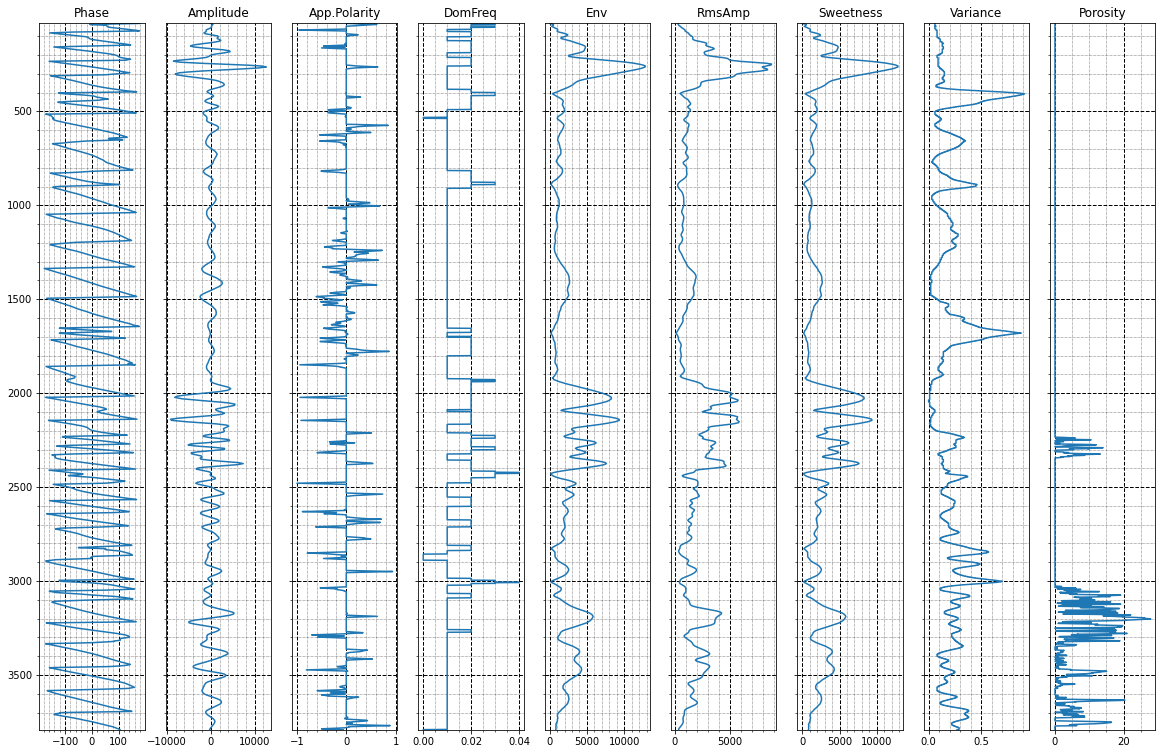

In [ ]:
rows, cols = 1,9
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20,13), sharey=True)
names = [ 'Phase', 'Amplitude', 'App.Polarity', 'DomFreq', 'Env', 'RmsAmp',
       'Sweetness', 'Variance', 'Porosity']
for i in range(cols):
    ax[i].plot(df.iloc[:,i+1], df.iloc[:,0],linewidth='1.5')
    ax[i].set_ylim(max(df.iloc[:, 0]), min(df.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black') #this is a comment
    ax[i].set_title('%s' %names[i])

In [ ]:
#@title Display columns names and data dimensions/shape

display(df.columns)
print("Yhat shapes of: ",df.shape)

Index(['MD', 'Phase', 'Amplitude', 'App.Polarity', 'DomFreq', 'Env', 'RmsAmp',
       'Sweetness', 'Variance', 'Porosity', 'Porcluster'],
      dtype='object')

Yhat shapes of:  (7524, 11)


In [ ]:
newdf = df[df.MD >= 2200]
display(newdf.head())
display(newdf.describe())

,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity,Porcluster
4340,2200.29,6.41,3123.30,0.00,0.01,3224.38,2915.26,3224.38,0.08,0.01,C
4341,2200.79,8.16,3117.32,0.00,0.01,3244.56,2900.34,3244.56,0.08,0.01,C
4342,2201.29,9.91,3109.90,0.00,0.01,3263.80,2885.17,3263.80,0.08,0.01,C
4343,2201.79,11.66,3101.04,0.00,0.01,3282.10,2869.74,3282.10,0.09,0.01,C
4344,2202.29,13.41,3090.74,0.00,0.01,3299.48,2854.05,3299.48,0.09,0.01,C


,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity
count,3184.00,3184.00,3184.00,3184.00,3184.00,3184.00,3184.00,3184.00,3184.00,3184.00
mean,2996.14,0.85,19.11,-0.00,0.01,2535.12,1859.21,2535.12,0.23,3.21
std,459.70,92.68,2022.71,0.19,0.01,1486.86,997.67,1486.86,0.10,5.45
min,2200.29,-173.64,-5141.32,-1.00,0.00,178.03,349.57,178.03,0.08,0.00
25%,2598.22,-79.18,-1280.65,0.00,0.01,1497.09,1163.68,1497.09,0.15,0.01
50%,2996.14,3.41,-161.77,0.00,0.01,2212.09,1600.45,2212.09,0.22,0.01
75%,3394.07,83.43,1307.41,0.00,0.02,3384.28,2511.73,3384.28,0.28,4.29
max,3792.00,167.04,7386.13,0.94,0.04,7619.47,4650.43,7619.47,0.70,27.92


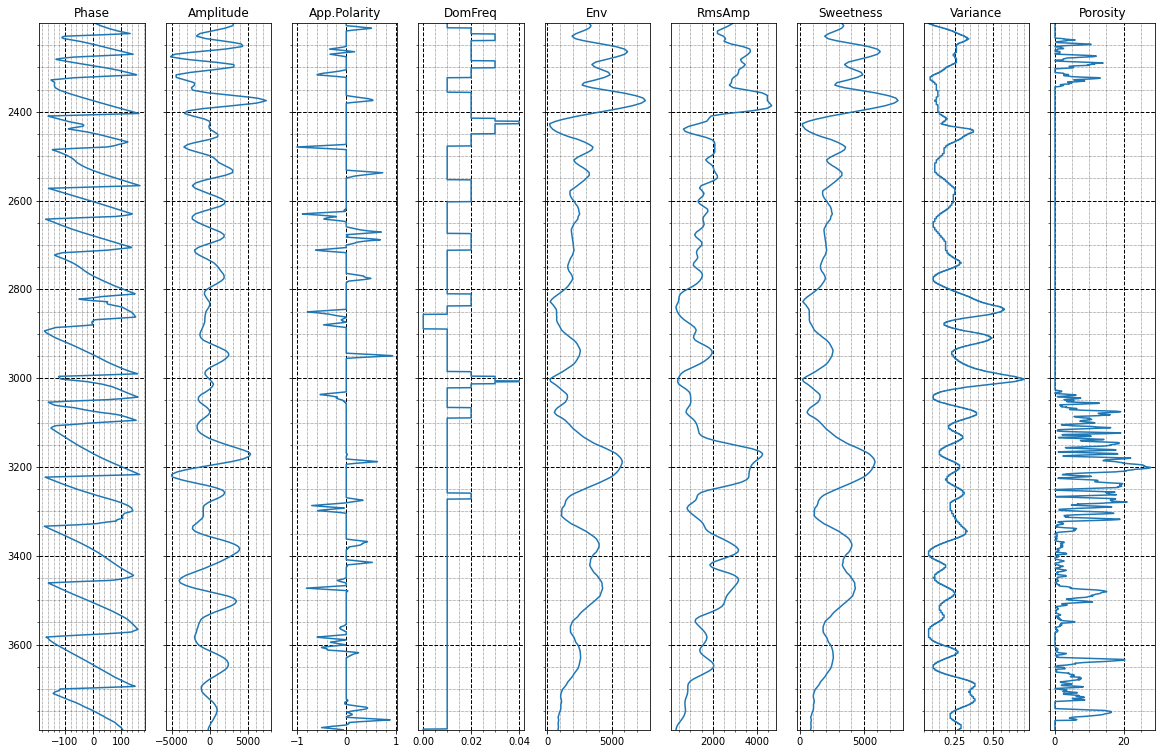

In [ ]:
rows, cols = 1,9
fig,ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20,13), sharey=True)
names = [ 'Phase', 'Amplitude', 'App.Polarity', 'DomFreq', 'Env', 'RmsAmp',
       'Sweetness', 'Variance', 'Porosity']
for i in range(cols):
    ax[i].plot(newdf.iloc[:,i+1], newdf.iloc[:,0],linewidth='1.5')
    ax[i].set_ylim(max(newdf.iloc[:, 0]), min(newdf.iloc[:, 0]))
    ax[i].minorticks_on()
    ax[i].grid(which='major', linestyle='dashed', linewidth='1', color='black')
    ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax[i].set_title('%s' %names[i])

In [ ]:

print('Maximum is : ',np.max(df['Porosity']))
print('Minimum is : ',np.min(df['Porosity']))
print('Average is : ',np.average(df['Porosity']))

Maximum is :  27.92
Minimum is :  0.0
Average is :  1.3603163211057947


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


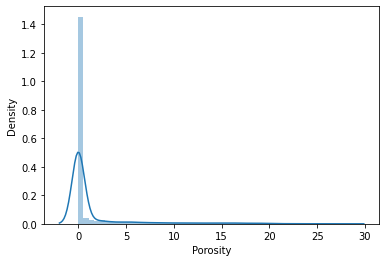

In [ ]:
sns.distplot(df['Porosity'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

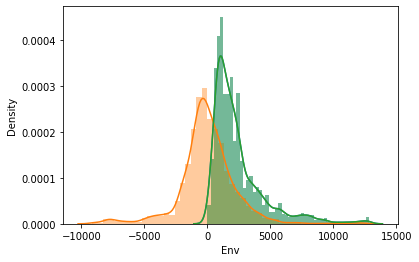

In [ ]:
sns.distplot(df['Sweetness'])
sns.distplot(df['Amplitude'])
sns.distplot(df['Env'])

## Data analysis 

In [ ]:
#@title Correlation matrix to show features relationships 
df.corr()

#corr() functions uses pearsman correlation by its default

,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity
MD,1.00,0.01,0.01,-0.01,-0.13,0.00,-0.00,0.00,0.15,0.42
Phase,0.01,1.00,0.02,-0.01,-0.03,-0.00,-0.01,-0.00,-0.02,0.02
Amplitude,0.01,0.02,1.00,0.37,-0.03,-0.01,0.01,-0.01,-0.05,0.02
App.Polarity,-0.01,-0.01,0.37,1.00,0.02,0.01,0.02,0.01,-0.05,0.03
DomFreq,-0.13,-0.03,-0.03,0.02,1.00,0.14,0.17,0.14,0.20,-0.10
Env,0.00,-0.00,-0.01,0.01,0.14,1.00,0.98,1.00,-0.35,0.11
RmsAmp,-0.00,-0.01,0.01,0.02,0.17,0.98,1.00,0.98,-0.37,0.10
Sweetness,0.00,-0.00,-0.01,0.01,0.14,1.00,0.98,1.00,-0.35,0.11
Variance,0.15,-0.02,-0.05,-0.05,0.20,-0.35,-0.37,-0.35,1.00,0.10
Porosity,0.42,0.02,0.02,0.03,-0.10,0.11,0.10,0.11,0.10,1.00


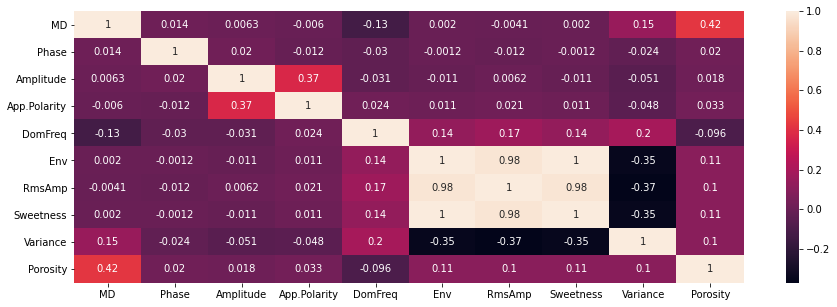

In [ ]:
#@title Plot correlation matrix to show relations between features
plt.figure(figsize = (15,5))
sns.heatmap(df.corr(),annot=True)
# try to make annot =  False

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


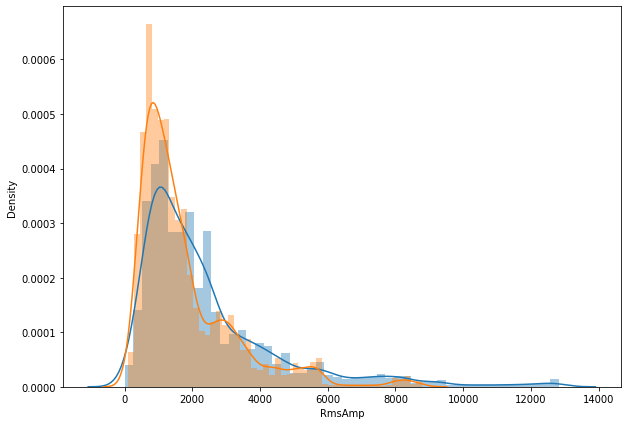

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(df['Env'])
sns.distplot(df['RmsAmp'])

In [ ]:
df.corr()

,MD,Phase,Amplitude,App.Polarity,DomFreq,Env,RmsAmp,Sweetness,Variance,Porosity
MD,1.00,0.01,0.01,-0.01,-0.13,0.00,-0.00,0.00,0.15,0.42
Phase,0.01,1.00,0.02,-0.01,-0.03,-0.00,-0.01,-0.00,-0.02,0.02
Amplitude,0.01,0.02,1.00,0.37,-0.03,-0.01,0.01,-0.01,-0.05,0.02
App.Polarity,-0.01,-0.01,0.37,1.00,0.02,0.01,0.02,0.01,-0.05,0.03
DomFreq,-0.13,-0.03,-0.03,0.02,1.00,0.14,0.17,0.14,0.20,-0.10
Env,0.00,-0.00,-0.01,0.01,0.14,1.00,0.98,1.00,-0.35,0.11
RmsAmp,-0.00,-0.01,0.01,0.02,0.17,0.98,1.00,0.98,-0.37,0.10
Sweetness,0.00,-0.00,-0.01,0.01,0.14,1.00,0.98,1.00,-0.35,0.11
Variance,0.15,-0.02,-0.05,-0.05,0.20,-0.35,-0.37,-0.35,1.00,0.10
Porosity,0.42,0.02,0.02,0.03,-0.10,0.11,0.10,0.11,0.10,1.00


In [ ]:
#@title Define dataset and Prediction Yhat

Xdf = newdf[[ 'Phase', 'Amplitude', 'App.Polarity', 'DomFreq', 'Env', 'Variance']]
y = newdf['Porosity']       

In [ ]:
print("Yhat shapes of: ",y.shape)
print("Xdf shapes of: ",Xdf.shape)

Yhat shapes of:  (3184,)
Xdf shapes of:  (3184, 6)


In [ ]:
#@title Train test split 25%
X_train, X_test, y_train, y_test = train_test_split(Xdf, y, test_size=0.25, random_state=101)

In [ ]:
Rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True)

Rfr.fit(X_train,y_train)
y_pred=Rfr.predict(X_test)

In [ ]:
Rfr.score(X_test,y_test)*100

83.12516098441853

In [ ]:
#@title Feature Importance 

feature_imp = pd.Series(Rfr.feature_importances_,index=Xdf.columns).sort_values(ascending=False)
feature_imp

Env            0.34
Variance       0.21
Amplitude      0.18
Phase          0.14
App.Polarity   0.07
DomFreq        0.06
dtype: float64

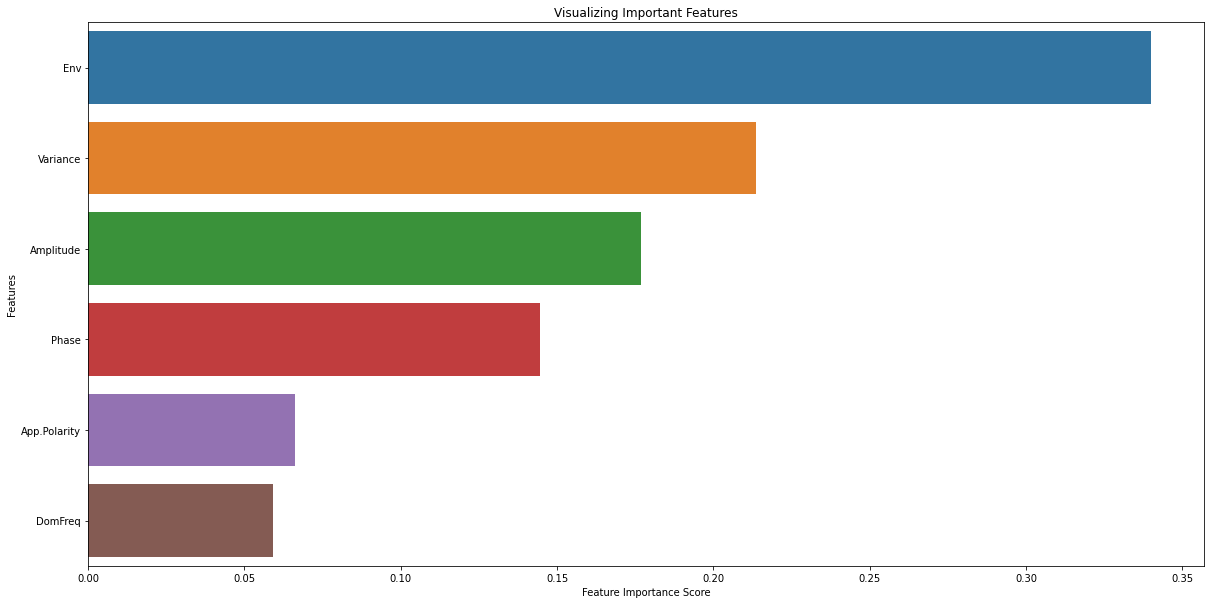

In [ ]:
#@title  Feature Importance Plotting
plt.figure(figsize=(20,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

In [ ]:
#@title Feature importing score
Rfr.score(X_train,y_train)

0.9130301528606897

10 0.9589991213960987
20 0.9581627522051777
30 0.9641811449758061
40 0.9656525275202494
50 0.9649074374261373
60 0.9655508976437742
70 0.9654483025477345
80 0.9655499356985227
90 0.9654671995965903
100 0.9662877898335319
110 0.9684063784411294
120 0.9674310766868937
130 0.9663790380123065
140 0.9670768932655285
150 0.9667471546976372
160 0.9677659980098285
170 0.9671684949753899
180 0.966829300582159
190 0.9672007145575391
200 0.9674878104717768
210 0.9672316517223024
220 0.966807661691455
230 0.9672454086067731
240 0.9675737160406428
250 0.9671249795715424
260 0.9685603864101658
270 0.9669554571738302
280 0.9678555959210392
290 0.9676499305343396


Text(0, 0.5, 'scores')

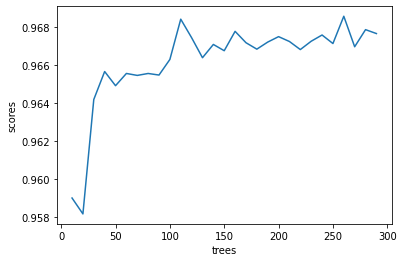

In [ ]:
#@title Number of trees testing
scoring = []
trees =[]
for i in range(10,300,10):
  Rfr = RandomForestRegressor(n_estimators=i, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=False)
  Rfr.fit(X_train,y_train)
  h = Rfr.score(X_train,y_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("trees")
plt.ylabel("scores")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


10 0.9538788756562193
20 0.9629321797308013
30 0.9650492767217125
40 0.9671045065183826
50 0.9650905460555661
60 0.9678410729769518
70 0.9669100750131608
80 0.9665775840325217
90 0.9678314919301939
100 0.9668214783634004
110 0.9665162088017097
120 0.9675136901159833
130 0.967500685927889
140 0.9673336023692518
150 0.9673249496175835
160 0.9671861621148381
170 0.9669560514538045
180 0.9671974334028924
190 0.9677176865137287
200 0.9668992977845899
210 0.9678550003622189
220 0.9678340648041608
230 0.9672765713790175
240 0.9674406015329151
250 0.9669960401207359
260 0.9675832461796355
270 0.9671687771273304
280 0.9664910814643248
290 0.9678153403064543


Text(0, 0.5, 'scores')

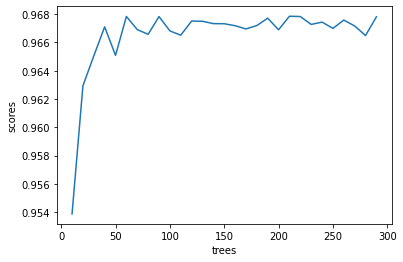

In [ ]:
#@title Number of Tress testing
scoring = []
trees =[]
for i in range(10,300,10):
  Rfr = RandomForestRegressor(n_estimators=i, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
  Rfr.fit(X_train,y_train)
  h = Rfr.score(X_train,y_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("trees")
plt.ylabel("scores")

In [ ]:
#@title OOB score
Rfr.oob_score_

0.9089523643791648

1 0.9930223733479211
3 0.966805366900101
5 0.9278109392950705
7 0.8895844889704373
9 0.8481577548715857
11 0.8123923278172477
13 0.7833596461791281
15 0.7482011030327747
17 0.7289921634054699
19 0.7025490689257868
21 0.6737905609629345
23 0.6599451962974694
25 0.645851149510822
27 0.6214583964119114
29 0.6103095879838212
31 0.5902050468986559
33 0.590299896830537
35 0.5774131189383509
37 0.5657768467818702
39 0.5458197300038238
41 0.5426448877881411
43 0.5262306834621613
45 0.5176916719457041
47 0.5121142445953533
49 0.5004947658071606


Text(0, 0.5, 'scores')

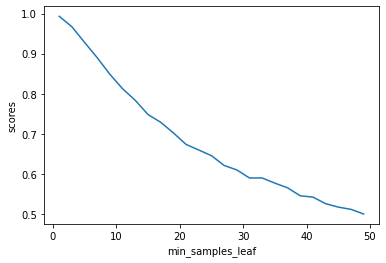

In [ ]:
#@title Testing minimum sample leaf
scoring = []
trees =[]
for i in range(1,51,2):
  Rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=i, max_features=0.5, n_jobs=-1, oob_score=False)
  Rfr.fit(X_train,y_train)
  h = Rfr.score(X_train,y_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
  
plt.plot(trees, scoring)
plt.xlabel("min_samples_leaf")
plt.ylabel("scores")

1 0.9886198604765334
2 0.9920520771480262
3 0.9924001856510896
4 0.9936102328647475
5 0.9934440891543889
6 0.9929358115237387


Text(0, 0.5, 'scores')

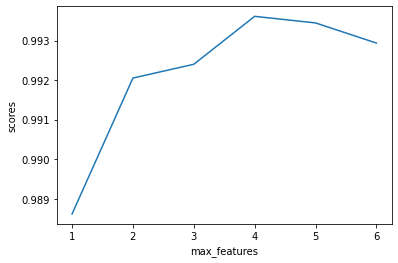

In [ ]:
#@title testing Maximum features 
scoring = []
trees =[]
for i in range(1,7,1):
  Rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=i, n_jobs=-1, oob_score=True)
  Rfr.fit(X_train,y_train)
  h = Rfr.score(X_train,y_train)
  print(i, h)
  scoring.append(h)
  trees.append(i)
plt.plot(trees, scoring)
plt.xlabel("max_features")
plt.ylabel("scores")

In [ ]:
#@title Building the random forest model
Rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features=4, n_jobs=-1, oob_score=True)
Rfr.fit(X_train,y_train)
Rfr.score(X_test,y_test)
#

0.9435026873553786

In [ ]:
#@title Estimating Errors
y_pred=Rfr.predict(X_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.6629415829145728
Mean Squared Error: 1.6248764308417083
Root Mean Squared Error: 1.2747064096652643


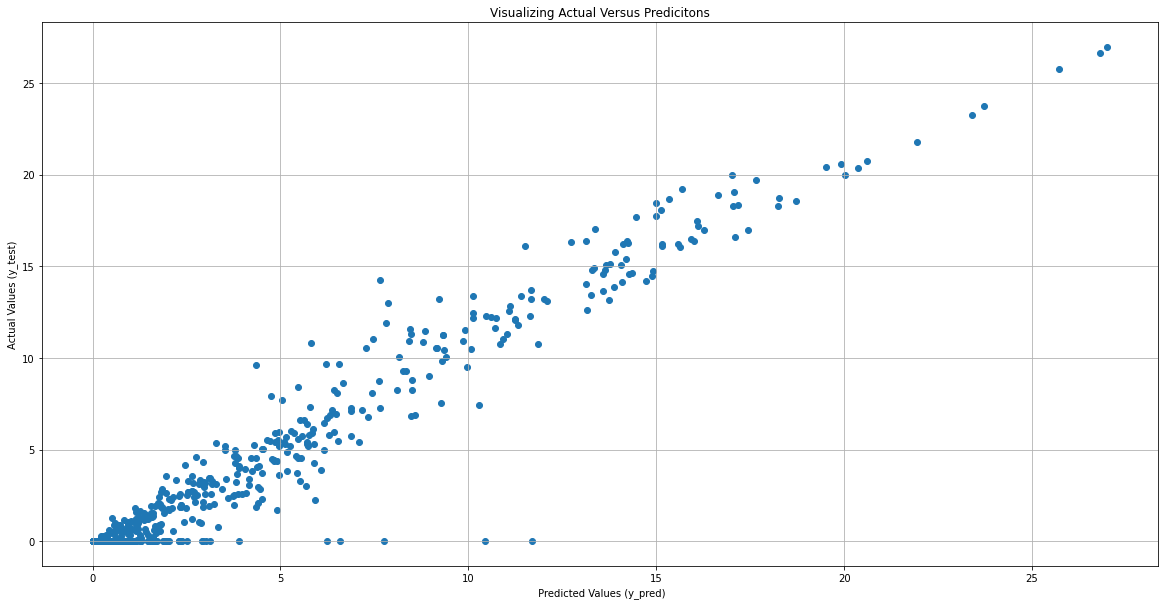

In [ ]:
#@title Plotting Actual versus Predicted 
plt.figure(figsize=(20,10))
plt.scatter(y_pred, y_test)
plt.xlabel(" Predicted Values (y_pred)")
plt.ylabel("Actual Values (y_test)")
plt.title("Visualizing Actual Versus Predicitons")
plt.grid()

In [ ]:
#@title Testing  Predicted vs Actual
print("Predictions mean is :", np.mean(y_pred), "Predictions SD is :", np.std(y_pred))
print("Test mean is :", np.mean(y_test), "Test SD is :", np.std(y_test))

Predictions mean is : 3.2435672110552765 Predictions SD is : 4.888706859036006
Test mean is : 3.190716080402026 Test SD is : 5.362857711047083


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


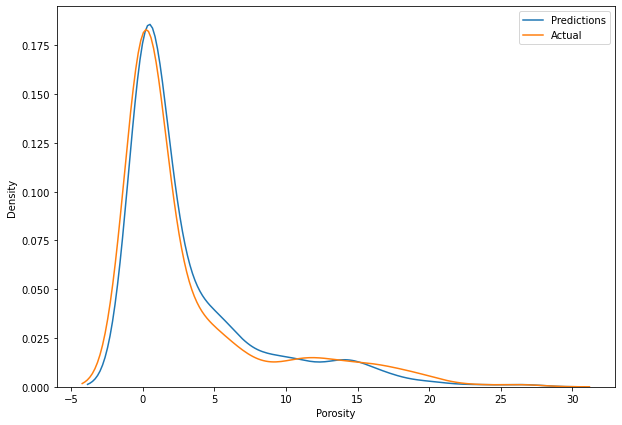

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(y_pred, hist=False)
sns.distplot(y_test, hist=False)
plt.legend(['Predictions', 'Actual'])
plt.show()

In [ ]:
test_pred = pd.DataFrame(y_pred,y_test)
corre = test_pred.corr()
print("Test-prediction correlations is :", corre.iloc[0,0])

Test-prediction correlations is : 1.0


In [ ]:

LR = LinearRegression()
LR.fit(X_train,y_train)
print(" Coeficients of the model :", LR.coef_)
print(" Coeficients of the model :", LR.intercept_)
predict_train = LR.predict(X_train)
predict_test = LR.predict(X_test)
print(" Training data MSE :", mean_squared_error(y_train, predict_train))
print(" Testing data MSE :", mean_squared_error(y_test, predict_test))
print(" R2 :", LR.score(X_train,y_train))



 Coeficients of the model : [ 2.17540553e-03 -6.56810164e-05  1.11458636e+00 -1.54143583e+02
  1.22822651e-03  1.19597636e+01]
 Coeficients of the model : -0.659984161349322
 Training data MSE : 26.746396879658644
 Testing data MSE : 27.329205083442258
 R2 : 0.11003916076878018
